In [1]:
library(cowplot)
library(tidyverse)

theme_set(theme_cowplot())
results <- '../results/'

palette_yn <- c('No' = 'gray80', 'Yes' = 'firebrick')


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
genes <- inner_join(read_tsv(paste0(results,'bcac/scored_genes.vegas.txt'), 
                             col_types = 'iciddddddcd'), 
                    read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), col_types = 'iciddddddcd'), 
           by = c("Chr", "Gene", "Start", "Stop"),
           suffix = c('_bcac', '_genesis'))

p_bonf_genes = .05 / nrow(genes)
genes <- genes %>%
    mutate(sign_genesis = ifelse(`Top-0.1-pvalue_genesis` < p_bonf_genes, 'Yes', 'No'),
           sign_bcac = ifelse(`Top-0.1-pvalue_bcac` < p_bonf_genes, 'Yes', 'No') )

gene_comparison <- genes %>%
    mutate(significant = (sign_genesis == 'Yes') | (sign_bcac == 'Yes') ) %>%
    ggplot(aes(x = -log10(`Top-0.1-pvalue_genesis`), 
               y = -log10(`Top-0.1-pvalue_bcac`),
               color = ifelse(significant, 'Yes', 'No'))) +
        geom_point() +
        geom_hline(yintercept = -log10(p_bonf_genes), color = 'gray50') +
        geom_vline(xintercept = -log10(p_bonf_genes), color = 'gray50') +
        labs(x = bquote('-log' [10] ~'(P-value' [GENESIS]~')'), 
             y = bquote('-log' [10] ~'(P-value' [BCAC]~')'),
             color = 'Significant', title = '') +
        theme(legend.position = 'bottom',
              axis.text = element_text(size = 10),
              axis.title = element_text(size = 12),
              legend.text = element_text(size = 12),
              legend.title = element_text(size = 12)) +
        scale_color_manual(values = palette_yn)

In [3]:
snps <- inner_join(
           read_tsv(paste0(results,'bcac/icogs_bcac_public_results_euro.genesis.assoc'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_bcac = P),
           read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_genesis = P),
           by = 'SNP')
p_bonf_snps = .05 / nrow(snps)

snps <- snps %>%
    mutate(sign_genesis = ifelse(p_genesis < p_bonf_snps, 'Yes', 'No'),
           sign_bcac = ifelse(p_bcac < p_bonf_snps, 'Yes', 'No') )

snp_comparison <- snps %>%
    mutate(significant = (sign_genesis == 'Yes') | (sign_bcac == 'Yes') ) %>%
    ggplot(aes(x = -log10(p_genesis), 
               y = -log10(p_bcac),
               color = ifelse(significant, 'Yes', 'No'))) +
        geom_point() +
        geom_hline(yintercept = -log10(p_bonf_snps), color = 'gray50') +
        geom_vline(xintercept = -log10(p_bonf_snps), color = 'gray50') +
        labs(x = bquote('-log' [10] ~'(P-value' [GENESIS]~')'), 
             y = bquote('-log' [10] ~'(P-value' [BCAC]~')'),
             color = 'Significant', title = '') +
        theme(legend.position = 'bottom',
              axis.text = element_text(size = 10),
              axis.title = element_text(size = 12),
              legend.text = element_text(size = 12),
              legend.title = element_text(size = 12)) +
        scale_color_manual(values = palette_yn)

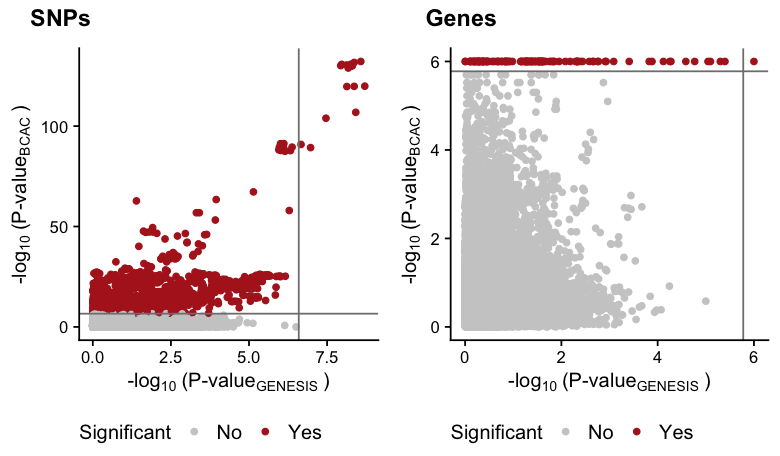

In [4]:
options(repr.plot.width=6.5, repr.plot.height=3.8)
plot_grid(snp_comparison, gene_comparison, labels = c('SNPs', 'Genes'))

# Comparison to BCAC

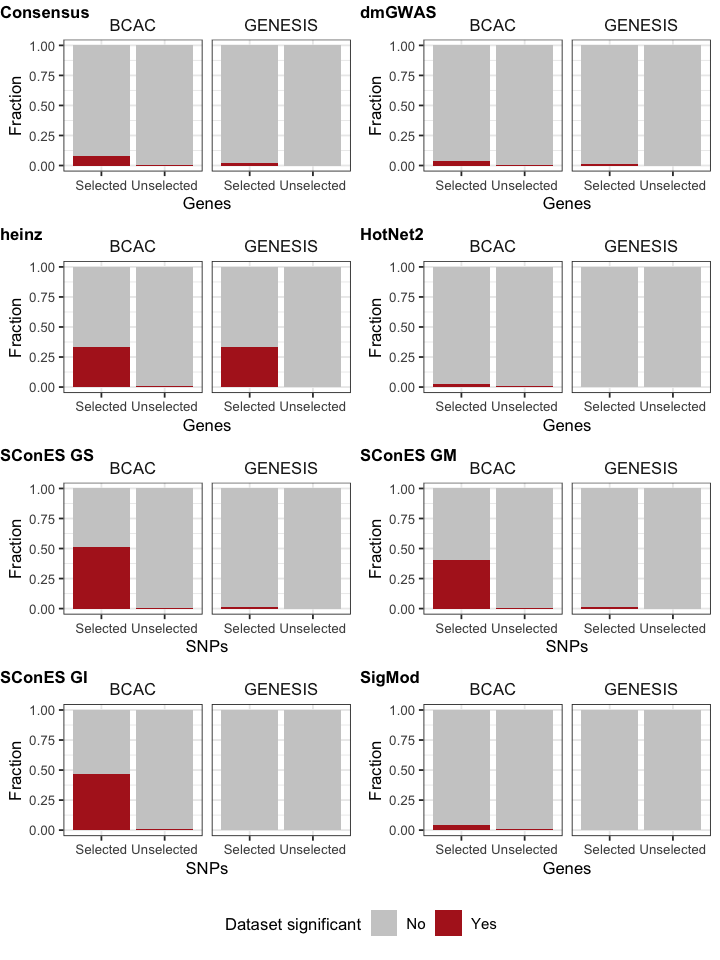

In [5]:
# GENE comparison
# use only genes that can be found in the PPIN
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), 
                col_types = cols(.default = 'c')) %>%
    rename(gene_a = `Official Symbol Interactor A`, 
           gene_b = `Official Symbol Interactor B`)

genes_in_ppi <- c(ppi$gene_a, ppi$gene_b)
genes <- inner_join(read_tsv(paste0(results,'bcac/scored_genes.vegas.txt'), 
                             col_types = 'iciddddddcd'), 
                    read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), col_types = 'iciddddddcd'), 
           by = c("Chr", "Gene", "Start", "Stop"),
           suffix = c('_bcac', '_genesis')) %>%
    filter(Gene %in% genes_in_ppi)

plot_selected_genes <- function(genes, selected) {
    
    p_bonf_genes = .05 / nrow(genes)
    
    genes %>%
        mutate(sign_genesis = ifelse(`Top-0.1-pvalue_genesis` < p_bonf_genes, 'Yes', 'No'),
               sign_bcac = ifelse(`Top-0.1-pvalue_bcac` < p_bonf_genes, 'Yes', 'No') ) %>%
        mutate(selected = ifelse(Gene %in% selected, 'Selected', 'Unselected')) %>%
        select(selected, sign_genesis, sign_bcac) %>%
        gather(where, sign, -selected) %>%
        mutate(where = ifelse(where == 'sign_genesis', 'GENESIS', 'BCAC')) %>%
        ggplot(aes(x = selected, fill = sign)) +
            geom_bar(position = 'fill') +
            labs(y = 'Fraction', x = 'Genes') +
            theme_bw() +
            scale_fill_manual(values = palette_yn) +
            facet_wrap(where ~ .) +
            theme(legend.position = 'none',
                  axis.text = element_text(size = 8),
                  axis.title = element_text(size = 10),
                  strip.text = element_text(size = 10),
                  strip.background = element_rect(fill="white", color = 'white'))
    
}

consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'), col_types = 'cdidlllllli')$gene
consensus_bcac <- plot_selected_genes(genes, consensus)

sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene
sigmod_bcac <- plot_selected_genes(genes, sigmod)

dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene
dmgwas_bcac <- plot_selected_genes(genes, dmgwas)

heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene
heinz_bcac <- plot_selected_genes(genes, heinz)

hotnet2 <- read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'ci')$gene
hotnet2_bcac <- plot_selected_genes(genes, hotnet2)

# scones comparison
snps <- inner_join(
           read_tsv(paste0(results,'bcac/icogs_bcac_public_results_euro.genesis.assoc'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_bcac = P),
           read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_genesis = P),
           by = 'SNP')

plot_selected_snps <- function(snps, selected) {
    
    p_bonf_snps = .05 / nrow(snps)
    
    snps %>%
    mutate(sign_genesis = ifelse(p_genesis < p_bonf_snps, 'Yes', 'No'),
           sign_bcac = ifelse(p_bcac < p_bonf_snps, 'Yes', 'No') ) %>%
    mutate(selected = ifelse(SNP %in% selected, 'Selected', 'Unselected')) %>%
    select(selected, sign_genesis, sign_bcac) %>%
    gather(where, sign, -selected) %>%
    mutate(where = ifelse(where == 'sign_genesis', 'GENESIS', 'BCAC')) %>%
    ggplot(aes(x = selected, fill = sign)) +
        geom_bar(position = 'fill') +
        labs(fill = 'Dataset significant', y = 'Fraction', x = 'SNPs') +
        theme_bw() +
        scale_fill_manual(values = palette_yn) +
        facet_wrap(where ~ .) +
        theme(legend.position = 'bottom',
              axis.text = element_text(size = 8),
              axis.title = element_text(size = 10),
              legend.text = element_text(size = 9),
              legend.title = element_text(size = 10),
              strip.text = element_text(size = 10),
              strip.background = element_rect(fill="white", color = 'white'))
    
}

gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gs_bcac <- plot_selected_snps(snps, gs)

gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gm_bcac <- plot_selected_snps(snps, gm)
legend <- cowplot::get_legend(gm_bcac)

gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gi_bcac <- plot_selected_snps(snps, gi)

sf4_no_leg <- plot_grid(consensus_bcac, dmgwas_bcac, 
                        heinz_bcac, hotnet2_bcac,
                        gs_bcac + theme(legend.position="none"), 
                        gm_bcac + theme(legend.position="none"), 
                        gi_bcac + theme(legend.position="none"), 
                        sigmod_bcac, ncol = 2, label_size = 10, hjust = 0,
                        labels = c('Consensus', 'dmGWAS', 'heinz', 'HotNet2', 
                                   'SConES GS', 'SConES GM', 'SConES GI', 'SigMod'))
options(repr.plot.width=6, repr.plot.height=8)
plot_grid(sf4_no_leg, legend, nrow = 2, rel_heights = c(12,1))

In [6]:
# GENE comparison
# use only genes that can be found in the PPIN
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), 
                col_types = cols(.default = 'c')) %>%
    rename(gene_a = `Official Symbol Interactor A`, 
           gene_b = `Official Symbol Interactor B`)

genes_in_ppi <- c(ppi$gene_a, ppi$gene_b)
genes <- inner_join(read_tsv(paste0(results,'bcac/scored_genes.vegas.txt'), 
                             col_types = 'iciddddddcd'), 
                    read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), col_types = 'iciddddddcd'), 
           by = c("Chr", "Gene", "Start", "Stop"),
           suffix = c('_bcac', '_genesis')) %>%
    filter(Gene %in% genes_in_ppi)

get_frac_genes <- function(genes, selected, method) {
    
    p_bonf_genes = .05 / nrow(genes)
    
    genes %>%
        mutate(sign_genesis = ifelse(`Top-0.1-pvalue_genesis` < p_bonf_genes, 'Yes', 'No'),
               sign_bcac = ifelse(`Top-0.1-pvalue_bcac` < p_bonf_genes, 'Yes', 'No') ) %>%
        mutate(selected = ifelse(Gene %in% selected, 'Selected', 'Unselected')) %>%
        mutate(method = method, marker = Gene) %>%
        select(method, marker, selected, sign_genesis, sign_bcac)
    
}

# scones comparison
snps <- inner_join(
           read_tsv(paste0(results,'bcac/icogs_bcac_public_results_euro.genesis.assoc'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_bcac = P),
           read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_genesis = P),
           by = 'SNP')

get_frac_snp <- function(snps, selected, method) {
    
    p_bonf_snps = .05 / nrow(snps)
    
    snps %>%
        mutate(sign_genesis = ifelse(p_genesis < p_bonf_snps, 'Yes', 'No'),
               sign_bcac = ifelse(p_bcac < p_bonf_snps, 'Yes', 'No') ) %>%
        mutate(selected = ifelse(SNP %in% selected, 'Selected', 'Unselected')) %>%
        mutate(method = method, marker = SNP) %>%
        select(method, marker, selected, sign_genesis, sign_bcac)
    
}

gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'), col_types = 'cdidlllllli')$gene
sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene
dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene
heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene
hotnet2 <- read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'ci')$gene

do.call(rbind, list(get_frac_snp(snps, gs, 'SConES GS'),
                    get_frac_snp(snps, gm, 'SConES GM'),
                    get_frac_snp(snps, gi, 'SConES GI'),
                    get_frac_genes(genes, consensus, 'Consensus'),
                    get_frac_genes(genes, sigmod, 'SigMod'),
                    get_frac_genes(genes, dmgwas, 'dmGWAS'),
                    get_frac_genes(genes, dmgwas, 'HotNet2'),
                    get_frac_genes(genes, heinz, 'heinz'))) %>%
    gather(where, sign, -selected, -method, -marker) %>%
    mutate(where = ifelse(where == 'sign_genesis', 'GENESIS', 'BCAC')) %>%
    group_by(method, where, selected, sign) %>%
    summarize(n = n(), markers = paste(marker, collapse = ',')) %>%
    group_by(method, where, selected) %>%
    mutate(n = round(n / sum(n), digits = 3),
           markers = ifelse(sign == 'Yes' | selected == 'Selected', markers, NA))

method    where   selected   sign n    
1  Consensus BCAC    Selected   No   0.921
2  Consensus BCAC    Selected   Yes  0.079
3  Consensus BCAC    Unselected No   0.994
4  Consensus BCAC    Unselected Yes  0.006
5  Consensus GENESIS Selected   No   0.978
6  Consensus GENESIS Selected   Yes  0.022
7  Consensus GENESIS Unselected No   1.000
8  dmGWAS    BCAC    Selected   No   0.960
9  dmGWAS    BCAC    Selected   Yes  0.040
10 dmGWAS    BCAC    Unselected No   0.994
11 dmGWAS    BCAC    Unselected Yes  0.006
12 dmGWAS    GENESIS Selected   No   0.989
13 dmGWAS    GENESIS Selected   Yes  0.011
14 dmGWAS    GENESIS Unselected No   1.000
15 heinz     BCAC    Selected   No   0.667
16 heinz     BCAC    Selected   Yes  0.333
17 heinz     BCAC    Unselected No   0.994
18 heinz     BCAC    Unselected Yes  0.006
19 heinz     GENESIS Selected   No   0.667
20 heinz     GENESIS Selected   Yes  0.333
21 heinz     GENESIS Unselected No   1.000
22 heinz     GENESIS Unselected Yes  0.000
23 HotNet2   BCAC    Selected   No   0.960
24 HotNet2   BCAC    Selected   Yes  0.040
25 HotNet2   BCAC    Unselected No   0.994
26 HotNet2   BCAC    Unselected Yes  0.006
27 HotNet2   GENESIS Selected   No   0.989
28 HotNet2   GENESIS Selected   Yes  0.011
29 HotNet2   GENESIS Unselected No   1.000
30 SConES GI BCAC    Selected   No   0.530
31 SConES GI BCAC    Selected   Yes  0.470
32 SConES GI BCAC    Unselected No   0.991
33 SConES GI BCAC    Unselected Yes  0.009
34 SConES GI GENESIS Selected   No   1.000
35 SConES GI GENESIS Unselected No   1.000
36 SConES GI GENESIS Unselected Yes  0.000
37 SConES GM BCAC    Selected   No   0.594
38 SConES GM BCAC    Selected   Yes  0.406
39 SConES GM BCAC    Unselected No   0.993
40 SConES GM BCAC    Unselected Yes  0.007
41 SConES GM GENESIS Selected   No   0.990
42 SConES GM GENESIS Selected   Yes  0.010
43 SConES GM GENESIS Unselected No   1.000
44 SConES GS BCAC    Selected   No   0.488
45 SConES GS BCAC    Selected   Yes  0.512
46 SConES GS BCAC    Unselected No   0.994
47 SConES GS BCAC    Unselected Yes  0.006
48 SConES GS GENESIS Selected   No   0.989
49 SConES GS GENESIS Selected   Yes  0.011
50 SConES GS GENESIS Unselected No   1.000
51 SigMod    BCAC    Selected   No   0.954
52 SigMod    BCAC    Selected   Yes  0.046
53 SigMod    BCAC    Unselected No   0.994
54 SigMod    BCAC    Unselected Yes  0.006
55 SigMod    GENESIS Selected   No   1.000
56 SigMod    GENESIS Unselected No   1.000
57 SigMod    GENESIS Unselected Yes  0.000
   markers                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [7]:
enrichment_test <- function(method, selected) {
    
    p_bonf_genes = .05 / nrow(genes)

    known_bcac_genes <- genes %>%
        filter(`Top-0.1-pvalue_bcac` < p_bonf_genes) %>%
        .$Gene
    
    known_selected <- length(intersect(known_bcac_genes, selected))
    known_not_selected <- length(setdiff(known_bcac_genes, selected))
    unknown_selected <- length(intersect(genes$Gene,selected)) - known_selected
    unknown_not_selected <- length(setdiff(genes$Gene,selected)) - known_not_selected

    p <- fisher.test(matrix(c(known_selected,known_not_selected,
                              unknown_selected, unknown_not_selected),
                            nrow = 2), alternative = 'greater')$p.value %>% 
        format(digits = 2)
    
    tibble(method = method, p = p, 
           `BCAC selected`   = known_selected,
           `BCAC unselected` = known_not_selected,
           `Other selected`   = unknown_selected,
           `Other unselected`   = unknown_not_selected)
    
}

enrichment_test_snp <- function(method, selected) {
    
    p_bonf_snps = .05 / nrow(snps)

    known_bcac_snps <- snps %>%
        filter(p_bcac < p_bonf_genes) %>%
        .$SNP
    
    known_selected <- length(intersect(known_bcac_snps, selected))
    known_not_selected <- length(setdiff(known_bcac_snps, selected))
    unknown_selected <- length(intersect(snps$SNP,selected)) - known_selected
    unknown_not_selected <- length(setdiff(snps$SNP,selected)) - known_not_selected

    p <- fisher.test(matrix(c(known_selected,known_not_selected,
                              unknown_selected, unknown_not_selected),
                            nrow = 2), alternative = 'greater')$p.value %>% 
        format(digits = 2)
    
    tibble(method = method, p = p, 
           `BCAC selected`   = known_selected,
           `BCAC unselected` = known_not_selected,
           `Other selected`   = unknown_selected,
           `Other unselected`   = unknown_not_selected)
    
}

list(enrichment_test('dmGWAS', dmgwas), 
     enrichment_test('heinz', heinz),
     enrichment_test('HotNet2', hotnet2),
     enrichment_test('LEAN', c()),
     enrichment_test_snp('SConES GS', gs),
     enrichment_test_snp('SConES GM', gm),
     enrichment_test_snp('SConES GI', gi),
     enrichment_test('SigMod', sigmod),
     enrichment_test('Consensus', consensus)) %>%
    do.call(rbind,.)

method    p        BCAC selected BCAC unselected Other selected
1 dmGWAS    0.00012    7             67            170           
2 heinz     0.019      1             73              2           
3 HotNet2   0.001      9             65            401           
4 LEAN      1          0             74              0           
5 SConES GS 0        830           1395            743           
6 SConES GM 0        707           1518            969           
7 SConES GI 4.9e-260 193           2032            213           
8 SigMod    0.00017    6             68            125           
9 Consensus 1.3e-06    7             67             82           
  Other unselected
1  11500          
2  11668          
3  11269          
4  11670          
5 192780          
6 192554          
7 193310          
8  11545          
9  11588